### Project Ideas

#### Using data from the National Oceanic and Atomospheric Administration (NOAA)
- Climate at a glance gives times series data for different parameters (avg/min/max temp, precipitation, palmer indices, cooling and heating days)
- Can average over different time scales
- Good visualizations are readily accessible
- Rankings data available
- Data comes from the nClimDiv Dataset
- JSON files are readily available

### Purpose of This Notebook

This notebook will be used to do some preliminary exploratory data analysis on the average temperature data for the contiguous United States starting from the year 1940. We basically just want to practice getting the publicly available data from NOAA (this data does not require an API) and visualize it. Basic visualizations will reveal the yearly seasonality. We'll also do some decomposition to get the trends for each state. Finally, we'll use the Dickey-Fuller test to check the stationarity of the temperature data for each state.

### Things To Do:

- Verify state codes
- Find a way to represent each state time series neatly in a single DataFrame
- Get data for the other indicators in the climate at a glance section
- Introduce functionality to save data into CSVs so that it doesn't need to be requested again later

In [1]:
import pandas as pd
import pandas.tseries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json

In [22]:
link1 = 'https://www.ncdc.noaa.gov/cag/statewide/time-series/1-pdsi-all-1-1940-2019.json?base_prd=true&begbaseyear=1940&endbaseyear=1940'
resp = requests.get(link1)
resp.status_code

200

### Getting Average Temperature Data for the Contiguous United States

In [37]:
links = [f'https://www.ncdc.noaa.gov/cag/statewide/time-series/{i}' + 
         '-tavg-all-1-1940-2019.json?base_prd=true&begbaseyear=1940&endbaseyear=1940'
         for i in range(1,49)]

links



['https://www.ncdc.noaa.gov/cag/statewide/time-series/1-tavg-all-1-1940-2019.json?base_prd=true&begbaseyear=1940&endbaseyear=1940',
 'https://www.ncdc.noaa.gov/cag/statewide/time-series/2-tavg-all-1-1940-2019.json?base_prd=true&begbaseyear=1940&endbaseyear=1940',
 'https://www.ncdc.noaa.gov/cag/statewide/time-series/3-tavg-all-1-1940-2019.json?base_prd=true&begbaseyear=1940&endbaseyear=1940',
 'https://www.ncdc.noaa.gov/cag/statewide/time-series/4-tavg-all-1-1940-2019.json?base_prd=true&begbaseyear=1940&endbaseyear=1940',
 'https://www.ncdc.noaa.gov/cag/statewide/time-series/5-tavg-all-1-1940-2019.json?base_prd=true&begbaseyear=1940&endbaseyear=1940',
 'https://www.ncdc.noaa.gov/cag/statewide/time-series/6-tavg-all-1-1940-2019.json?base_prd=true&begbaseyear=1940&endbaseyear=1940',
 'https://www.ncdc.noaa.gov/cag/statewide/time-series/7-tavg-all-1-1940-2019.json?base_prd=true&begbaseyear=1940&endbaseyear=1940',
 'https://www.ncdc.noaa.gov/cag/statewide/time-series/8-tavg-all-1-1940-2019

In [51]:
def noaa_resp_to_ts(URL):
    """
    Accepts a link for JSON output from the publicly available NOAA climate at a glance data.
    Returns a timeseries  of this data.
    """
    response = requests.get(URL)
    
    try:
        response.raise_for_status()
    except requests.exceptions.HTTPError as e:
        # Whoops it wasn't a 200
        return "Error: " + str(e)
    
    data = response.json()
    dates = list(data['data'].keys())
    dates = [date[:4] + '-' + date[4:] for date in dates]
    dates = pd.to_datetime(dates, format='%Y-%m')
    series = [v['value'] for v in data['data'].values()]
    ts = pd.Series(series, index=dates)
    ts = ts.astype(float)
    
    return ts

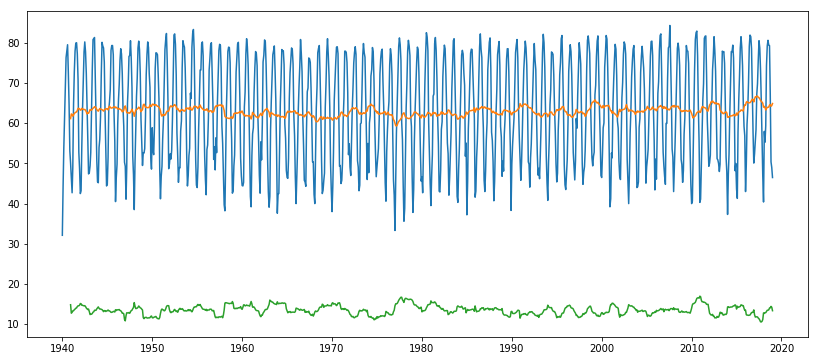

In [36]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(avg_temp_tseries[15])
ax.plot(avg_temp_tseries[15].rolling(12).mean())
ax.plot(avg_temp_tseries[15].rolling(12).std())

### Getting Data for the Other Metrics

In [24]:
metrics = ['tavg', 'tmax', 'tmin', 'pcp', 'cdd', 'hdd', 'pdsi', 'phdi', 'pmdi']
url_dict = {metric: [f'https://www.ncdc.noaa.gov/cag/statewide/time-series/{i}' + 
                     f'-{metric}-all-1-1940-2019.json?base_prd=true&begbaseyear=1940&endbaseyear=1940'
                     for i in range(1,49)] for metric in metrics}

In [59]:
all_tseries = {metric: [noaa_resp_to_ts(url) for url in url_dict[metric]]
               for metric in metrics}

In [72]:
all_dfs = {metric: pd.DataFrame(all_tseries[metric]).T for metric in metrics}

In [77]:
states = ["AL", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
          "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH",
          "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA",
          "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA",
          "WV", "WI", "WY"]
len(states)

48

In [78]:
for metric in metrics:
    all_dfs[metric].columns = states